# **Brief description of the problem and data**

This Kaggle competition is about classifying texts taken from Twitter using Natural Language Processing (NLP) to classify which are about real disasters and which are not. 

The complexity of the task is demonstrated using the sample Tweet provided by the competition: "LOOK AT THE NIGHT SKY LAST NIGHT IT WAS ABLAZE" where the author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away but it is less clear to a machine that it is not referencing a real disaster.

The dataset consists of 10,000 tweets that were hand classified.

# **Load Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import random
import wordcloud
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#from functools import reduce
#from nltk.stem import PorterStemmer, WordNetLemmatizer

# **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [3]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


From a high level look at the datasets it is observed:

* The training set contains 7,613 entries while the testing dataset contains 3,263 entries
* Both datasets contain 4 columns: ID, Keyword, Location, Text
* The training dataset contains 1 additional column which we will be predicting for the test dataset: Target

We will evaluate the fields further below.


In [7]:
train_data['target'].value_counts().to_frame()

,target
0,4342
1,3271


Text(0, 0.5, 'Count')

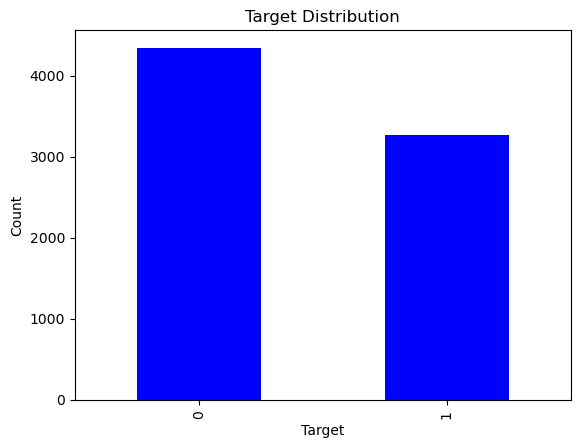

In [8]:
train_data.groupby(['target'])['target'].count().plot(kind='bar', color = 'blue', title='Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

Text(0.5, 0, 'Count')

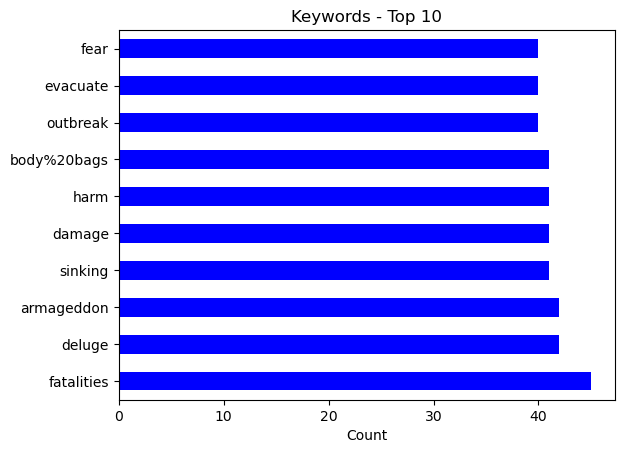

In [9]:
train_data['keyword'].value_counts()[:10].plot(kind='barh', color='blue')
plt.title("Keywords - Top 10")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

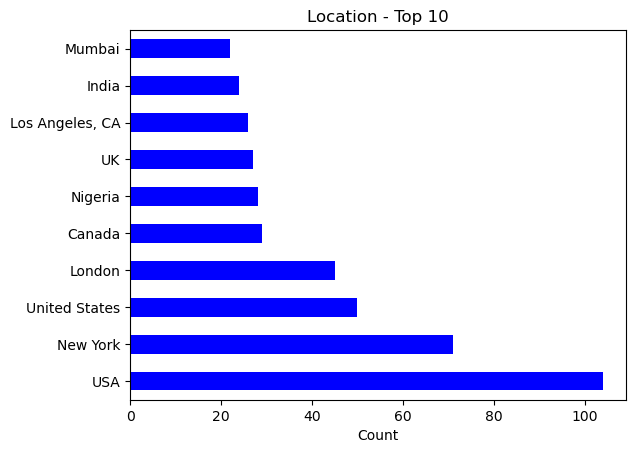

In [10]:
train_data['location'].value_counts()[:10].plot(kind='barh', color='blue')
plt.title("Location - Top 10")
plt.xlabel("Count")

* From the above analysis of the training dataset, we can see approximately 60% of the Tweets reference a non-disaster (target=0) versus a disaster (target=1).
* The keywords field contains a word that represents the overall text.
* The location field contains a geographical location from which the text originated, in some cases a country name while in others a city location.  
* We can consider cleaning up the keyword and location for empty value or standardization yet they will not directly be used in the NLP model below so will defer doing so within the scope of this project.
* Below, we will examine the primary field for our analysis which will be the 'text' derived from the Tweets.

Text(0.5, 0, '# Words')

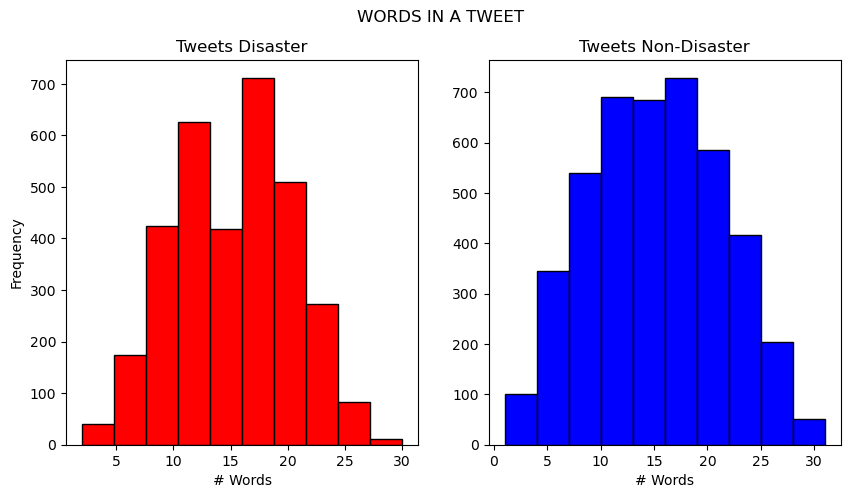

In [11]:
text_length = train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('WORDS IN A TWEET')
ax1.hist(text_length, color='red', edgecolor='black')
ax1.set_title('Tweets Disaster')
ax1.set_xlabel('# Words')
ax1.set_ylabel('Frequency')
text_length = train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_length,color='blue', edgecolor='black')
ax2.set_title('Tweets Non-Disaster')
ax2.set_xlabel('# Words')

Above we have a histogram of the average number of words in each text for both disaster and non-disaster related Tweets.
In both cases, the average number of words tends to be approximately 15 with more variance from the average for disaster versus non-disaster tweets.

Text(0.5, 1.0, 'Negative')

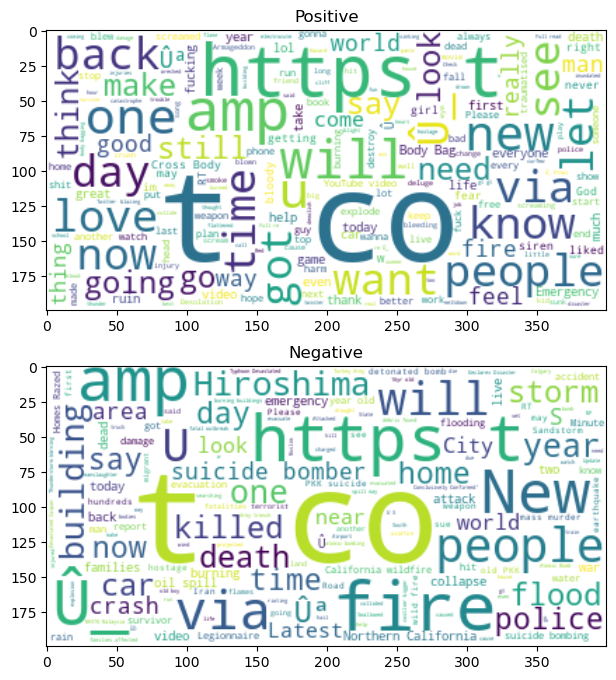

In [12]:
positive_cases = "".join(train_data[train_data['target'] == 0]['text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

The above word cloud shows the most frequent words for each of our target categories.  While some trends start appearing, the data overall seems 'messy' with an opportunity to clean it up for greater insight and accuracy.  Below we will clean the data by applying lower case and removing:

* Punctation
* Common stopwords  
* Words less than 4 letters
* Non-alphabet characters

In [15]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 letters
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])


In [16]:
train_data['clean_text'] = train_data['text'].apply(lambda x: x.lower())
train_data['clean_text'] = train_data['clean_text'].apply(remove_less_than)
train_data['clean_text'] = train_data['clean_text'].apply(remove_non_alphabet)
train_data['clean_text'] = train_data['clean_text'].apply(remove_stopwords)
train_data['clean_text'] = train_data['clean_text'].apply(remove_punctuation)
print('done')

done


In [18]:
train_data.head(5)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked notified evacuation shelter pl...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,sent photo ruby smoke pours school


Text(0.5, 1.0, 'Negative')

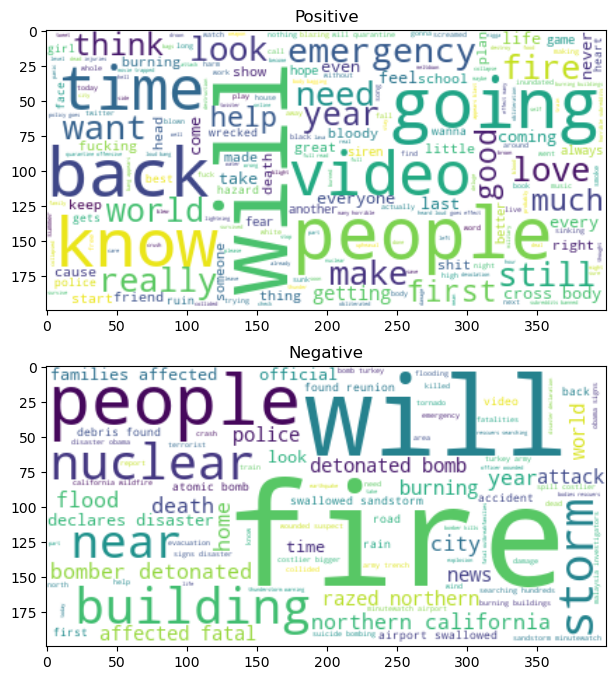

In [19]:
positive_cases = "".join(train_data[train_data['target'] == 0]['clean_text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['clean_text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

With the result of the text cleanup, the above word clouds provide greater insight to the words driving the target characterisation.   The clarity of the cleansed text will be helpful in the below model.  While there are additional opportunities to address mis-spellings and abbreviations within the text further, the current cleansed text will suffice within the scope of this week's assignment.

# **Model Architecture**

We will build a long short term memory network (LSTM) model which is a variety of recurrent neural network discussed during the class lecture.  The LSTM architecture provides a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory". The intuition behind the LSTM architecture is to create an additional module in a neural network that effectively learns which information might be needed later on in a sequence and when that information is no longer needed - making it a great architecture for natural language processing where we need the network to learn grammatical dependencies.

First, we will tokenize each text sentence. Tokenization will break down the sentences into individual words in order to create a matrix of the relationship between those words.  In totality, this is referred to as a corpus.

In [20]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
x = tokenizer.texts_to_sequences(train_data['clean_text'].values)
x = pad_sequences(x)
x.shape

(7613, 16)

In [22]:
#XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.
# reference: https://www.tensorflow.org/xla
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [23]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = x.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


# **Results and Analysis**

To evaluate the results, we will split the training data 80% for training the model and 20% to validate the results as shown below:

In [25]:
y = train_data['target']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 777)

In [26]:
model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 8s 21ms/step - loss: 0.5700 - accuracy: 0.6959 - val_loss: 0.4797 - val_accuracy: 0.7741
Epoch 2/10
191/191 [==============================] - 3s 18ms/step - loss: 0.3925 - accuracy: 0.8271 - val_loss: 0.4859 - val_accuracy: 0.7768
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3386 - accuracy: 0.8504 - val_loss: 0.5221 - val_accuracy: 0.7722
Epoch 4/10
191/191 [==============================] - 3s 18ms/step - loss: 0.3088 - accuracy: 0.8660 - val_loss: 0.5768 - val_accuracy: 0.7663
Epoch 5/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2866 - accuracy: 0.8762 - val_loss: 0.5985 - val_accuracy: 0.7590
Epoch 6/10
191/191 [==============================] - 4s 19ms/step - loss: 0.2663 - accuracy: 0.8900 - val_loss: 0.6432 - val_accuracy: 0.7452
Epoch 7/10
191/191 [==============================] - 3s 18ms/step - loss: 0.2515 - accuracy: 0.8910 - val_loss: 0.6716 - val_accuracy: 0.7420

In [27]:
y_pred = model.predict(x_test).round()
print(y_pred)

48/48 [==============================] - 1s 4ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


<AxesSubplot:>

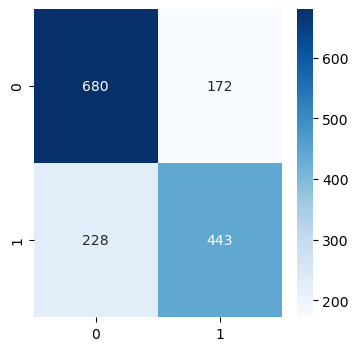

In [28]:
confuse = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(confuse, annot=True, fmt='g', cmap='Blues')

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       852
           1       0.72      0.66      0.69       671

    accuracy                           0.74      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



The confusion matrix visualizes and summarizes the performance of the classification:

* Precision, the ratio between the true positives and all the positives, checks the accuracy of the postive class. Out of all the tweets the the model predicted  would be disaster related 75% actual are.
* Recall, the ratio between the number of true positives and number of false negatives, is a measure of the model correctly identifying true positives. Out of all the tweets that were related to disasters, the model predicted this outcome for 81%.
* The f1-score of 78% tells us the model did a pretty good job of predicting if the text was related to true disaster.
* Overall accuracy is 74%

We can adjust the model parameters to attempt to improve the results.   Let's try to increase the learning rate and reduce the drop rate:

In [30]:
embed_dim = 32
lstm_out = 32
model2 = Sequential()
model2.add(Embedding(max_features, embed_dim,input_length = x.shape[1]))
model2.add(Dropout(0.1))
model2.add(LSTM(lstm_out, dropout=0.1, recurrent_dropout=0.2))
model2.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.10)
model2.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
model2.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 7s 21ms/step - loss: 0.6148 - accuracy: 0.6821 - val_loss: 0.5721 - val_accuracy: 0.7039
Epoch 2/10
191/191 [==============================] - 4s 19ms/step - loss: 0.5229 - accuracy: 0.7478 - val_loss: 0.6016 - val_accuracy: 0.6993
Epoch 3/10
191/191 [==============================] - 3s 18ms/step - loss: 0.5264 - accuracy: 0.7445 - val_loss: 0.6131 - val_accuracy: 0.6894
Epoch 4/10
191/191 [==============================] - 4s 21ms/step - loss: 0.5055 - accuracy: 0.7562 - val_loss: 0.6568 - val_accuracy: 0.6953
Epoch 5/10
191/191 [==============================] - 4s 20ms/step - loss: 0.5030 - accuracy: 0.7612 - val_loss: 0.6443 - val_accuracy: 0.6756
Epoch 6/10
191/191 [==============================] - 3s 18ms/step - loss: 0.4909 - accuracy: 0.7657 - val_loss: 0.7302 - val_accuracy: 0.6888
Epoch 7/10
191/191 [==============================] - 3s 18ms/step - loss: 0.4841 - accuracy: 0.7750 - val_loss: 0.6568 - val_accuracy: 0.6993

In [34]:
y_pred = model2.predict(x_test).round()
print(y_pred)

48/48 [==============================] - 0s 4ms/step
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


<AxesSubplot:>

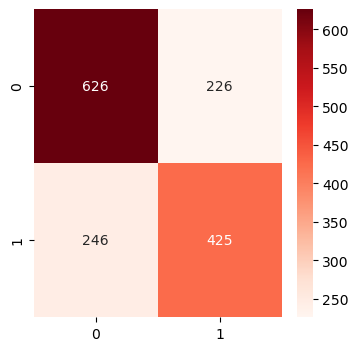

In [35]:
confuse = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(confuse, annot=True, fmt='g', cmap='Reds')

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       852
           1       0.65      0.63      0.64       671

    accuracy                           0.69      1523
   macro avg       0.69      0.68      0.68      1523
weighted avg       0.69      0.69      0.69      1523



The second model did slightly worse than the first model.   While we can continue to adjust hyperparameters, add layers and further cleanse the data or switch to another model architecture completly like BERT, within the scope of the weekly assignment we will proceed with applying the original model against the test dataset for competition submission.

# **Submission**

We will clean the test dataset, fit the model and make predictions for submission:

In [39]:
test_data.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard different stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot geese fleeing across save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


In [40]:
test_data['clean_text'] = test_data['text'].apply(lambda x: x.lower())
test_data['clean_text'] = test_data['clean_text'].apply(remove_less_than)
test_data['clean_text'] = test_data['clean_text'].apply(remove_non_alphabet)
test_data['clean_text'] = test_data['clean_text'].apply(remove_stopwords)
test_data['clean_text'] = test_data['clean_text'].apply(remove_punctuation)

l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
x = tokenizer.texts_to_sequences(train_data['clean_text'].values)
x = pad_sequences(x, maxlen =l)

tokenizer.fit_on_texts(train_data['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test_data['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

print('done')

done


In [41]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = x.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [42]:
model.fit(x,y, epochs = 10,validation_split = 0.2 ,batch_size=32)

Epoch 1/10
191/191 [==============================] - 35s 151ms/step - loss: 0.5420 - accuracy: 0.7233 - val_loss: 0.5118 - val_accuracy: 0.7623
Epoch 2/10
191/191 [==============================] - 29s 151ms/step - loss: 0.3724 - accuracy: 0.8415 - val_loss: 0.5554 - val_accuracy: 0.7288
Epoch 3/10
191/191 [==============================] - 28s 149ms/step - loss: 0.3008 - accuracy: 0.8737 - val_loss: 0.5608 - val_accuracy: 0.7269
Epoch 4/10
191/191 [==============================] - 28s 149ms/step - loss: 0.2537 - accuracy: 0.8966 - val_loss: 0.7196 - val_accuracy: 0.7144
Epoch 5/10
191/191 [==============================] - 28s 149ms/step - loss: 0.2135 - accuracy: 0.9130 - val_loss: 0.7716 - val_accuracy: 0.6861
Epoch 6/10
191/191 [==============================] - 28s 149ms/step - loss: 0.1709 - accuracy: 0.9276 - val_loss: 1.0519 - val_accuracy: 0.6861
Epoch 7/10
191/191 [==============================] - 28s 148ms/step - loss: 0.1506 - accuracy: 0.9327 - val_loss: 1.1651 - val_ac

In [43]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 3s 23ms/step


Text(0, 0.5, 'Count')

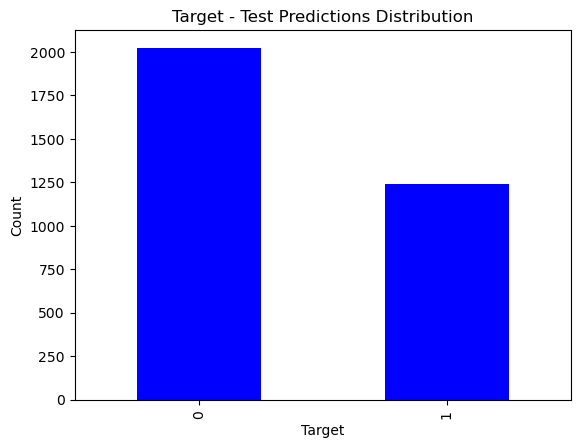

In [45]:
submission.groupby(['target'])['target'].count().plot(kind='bar', color = 'blue', title='Target - Test Predictions Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

# **Conclusion**

adfadfadfadf